In [1]:
import os
import gzip
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec
import seaborn as sns

sns.set("talk", style="ticks")

from copy import deepcopy as copy
from astropy.io import fits

from tqdm import tqdm

from pyFIT3D.modelling.stellar import SSPModels
from pyFIT3D.common.auto_ssp_tools import auto_ssp_elines_single_main
from lvmdap.modelling.synthesis import StellarSynthesis
from lvmdap.io import read_iso
from lvmdap.analysis.plotting import *

import warnings
warnings.filterwarnings("ignore")

import contextlib
import sys

class DummyFile(object):
    def write(self, x): pass

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = DummyFile()
    yield
    sys.stdout = save_stdout

In [2]:
SNR = 20 # 5, 10, 20, 50, 100, 150
experiment = f"ssp_snr{SNR}"
experiment = "ssp"
obs_path = f"_data/{experiment}/obs/"
out_path = f"_data/{experiment}/out/"
fig_path = f"_data/{experiment}/figs/"
os.makedirs(obs_path, exist_ok=True)
os.makedirs(out_path, exist_ok=True)
os.makedirs(fig_path, exist_ok=True)

ZSUN = 0.017

CURRENT_SSPS = os.path.join("../../_fitting-data/_basis_ssps", "MaStar_CB19.all_1_5.fits.gz")

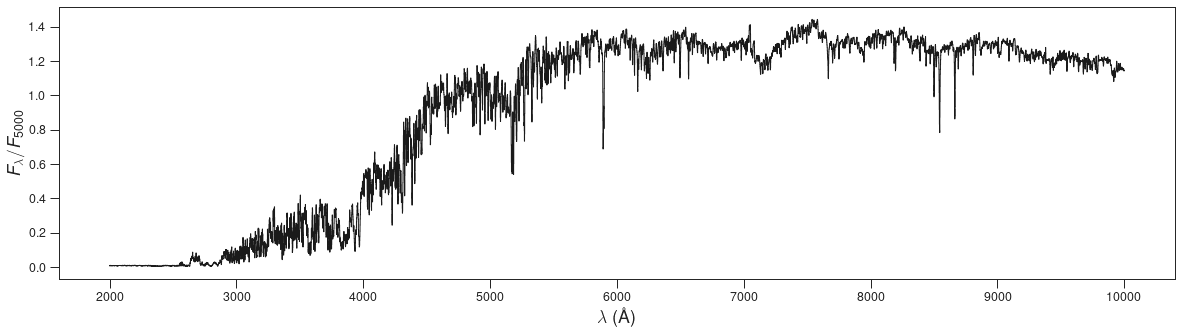

In [3]:
ssp = SSPModels(CURRENT_SSPS)

ssp_idx = 2415
# print(ssp.age_models[ssp_idx], np.log10(ssp.metallicity_models[ssp_idx]/ZSUN))

plt.figure(figsize=(20,5))
plt.step(ssp.wavelength, ssp.flux_models[ssp_idx], "k", lw=1)
plt.xlabel("$\lambda$ (\AA)")
plt.ylabel(fr"$F_\lambda/F_{{{int(ssp.normalization_wavelength)}}}$");

In [15]:
ISOCHRONE_PATH = "../../_fitting-data/_isochrones"
isoc_list = sorted([os.path.join(root,file) for root, subs, files in os.walk(ISOCHRONE_PATH) for file in files if file.endswith("Vega_mags.gz")])

iso_pars = {}
for file in tqdm(isoc_list, desc="reading isochrones", ascii=True, unit="file"):
    f = gzip.open(file, "rb")
    for line in f.readlines():
        if not line.startswith(b"#"): break
    iso_met = float(os.path.basename(file).split("_")[1][1:])/1e3
    iso_age = float(line.split()[5])
    iso_pars[file] = (iso_met,iso_age)

ssp_ages = np.log10(np.unique(ssp.age_models) * 1e9)
iso_filt = sorted([((iso_age,iso_met),file) for file, (iso_met,iso_age) in iso_pars.items() for ssp_age in ssp_ages if np.isclose(iso_age,ssp_age)])

true_param_table = []
for ised in tqdm(range(ssp.flux_models.shape[0]), desc="writing spectra", ascii=True, unit="SED"):
    out_file = f'bc19-{ssp.age_models[ised]}-{ssp.metallicity_models[ised]}-sed'.replace(".","p") + ".txt"
    
    sed_path = os.path.join(obs_path,out_file)
    if not os.path.isfile(sed_path):
        sigma_flux = (ssp.flux_models*ssp.mass_to_light[:,None])[ised]/SNR
        clean_flux = (ssp.flux_models*ssp.mass_to_light[:,None])[ised]
        noisy_flux = clean_flux + np.random.randn(clean_flux.size)*sigma_flux
        
        np.savetxt(sed_path, np.column_stack((
            np.arange(ssp.wavelength.size, dtype=int),
            ssp.wavelength,
            noisy_flux,
            sigma_flux
        )))

    iso = read_iso(iso_filt[ised][1])
    # GAIA mask
    #mask = (iso.GB-iso.GR>-0.7)&(-5<=iso.G)&(iso.G<=15)
    mask = (2300<=10**iso.log_T)&(10**iso.log_T<=12000)&(0<=iso.log_g)&(iso.log_g<=6)
    iso = iso.loc[mask]
    w = 10**(-0.4*iso.V)
    w = iso.mass
    w /= w.sum()
    true_param_table.append([
        out_file,
        os.path.basename(iso_filt[ised][1]),
        (w*iso.log_T).sum(),
        (w*iso.log_g).sum(),
        np.nan_to_num(np.log10(ssp.metallicity_models[ised]/ZSUN), neginf=0),
        0.0
    ])

true_param_table = pd.DataFrame(data=true_param_table, columns="sed_file iso_file TEFF LOGG MET ALPHAM".split())
true_path = os.path.join(f"_data/{experiment}", f"true-{experiment}-params.csv")
if not os.path.isfile(true_path):
    true_param_table.to_csv(true_path, index=False)

writing spectra: 100%|#############################################################################################################################| 3360/3360 [01:37<00:00, 34.35SED/s]


In [18]:
# See the similar script to run the analysis with intrumental dispersion: 
#      bin/auto_ssp_elines_rnd_sigma_inst.py
#

# using the initial values:
#
# Instrumental dispersion: 2.5 AA
sigma_inst = 0.001

# Masks:
#     File with list of ranges of wavelength to be masked in whole analysis
mask_list = None#'../../_fitting-data/_configs/mask_elines.txt'

######################
######################
# Non linear analysis: (redshift, observed dispersion and dust attenuation)
#     wavelength range: 
#         [3850, 4700] AA for the redshift and sigma analysis
#         [3800, 7000] AA for the dust attenuation
w_min_max = [3650, 10000]
nl_w_min_max = [3850, 4700]

#     models:
#         Miles solar 3 models
ssp_nl_fit_file = '../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-5.fits.gz'

#     emission lines to be masked:
elines_mask_file = '../../_fitting-data/_configs/MaNGA/emission_lines_long_list.txt'

#     redshift:
#         initial value: 0.02449
#                 delta: 0.0001
#                   min: 0.02349
#                   max: 0.02549
redshift_set = [0,0,0,0]

#     dispersion: (km/s)
#         initial value: 30
#                 delta: 20
#                   min: 1
#                   max: 150
sigma_set = [0,0,0,0]

#     dust attenuation at V band (mag):
#         initial value: 0.3
#                 delta: 0.15
#                   min: 0
#                   max: 1.6
AV_set = [0,0,0,0]

# SSP analysis:
#     wavelength range:
#         [3800, 7000] AA
#
#     models:
#         GSD01 156 models
ssp_file = '../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-100.fits.gz'
par_file = '../../_fitting-data/_basis_mastar_v2/stellar-basis-params-100.fits.gz'

#     configuration file:
config_file = '../../_fitting-data/_configs/auto_ssp_V500_several_Hb.config'

# plot options
stellar_param = fits.open(par_file)

labels = {"TEFF":r"$\log{T_\text{eff}}$", "LOGG":r"$\log{g}$", "MET":r"$[\text{Fe}/\text{H}]$", "ALPHAM":r"$[\alpha/\text{Fe}]$"}
cmap = "binary_r"
color = sns.color_palette(cmap)[0]

In [19]:
import subprocess


subprocess.run(["tsp", "-S", "30"])
for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc=f"fitting {experiment}", ascii=True, unit="SED"):
    label = row.sed_file.replace("-sed.txt", "")
    if os.path.isfile(os.path.join(out_path,label)): continue
    subprocess.run(f"tsp lvm-dap {os.path.join(obs_path,row.sed_file)} {ssp_file} {sigma_inst} {label} --rsp-nl-file {ssp_nl_fit_file} --w-range {' '.join(map(str,w_min_max))} --w-range-nl {' '.join(map(str,nl_w_min_max))} --redshift {' '.join(map(str,redshift_set))} --sigma {' '.join(map(str,sigma_set))} --AV {' '.join(map(str,AV_set))} -c --ignore-gas --config-file {config_file} --output-path {out_path}".split(), capture_output=True)

fitting ssp: 100%|###############################################################################################################################| 3360/3360 [00:00<00:00, 4585.47SED/s]


In [20]:
for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc="plotting results", ascii=True, unit="SED"):
    label = row.sed_file.replace("-sed.txt", "")
    
    fig_file = os.path.join(fig_path, f"{label}.png")
    if not os.path.isfile(fig_file):
        model = pd.read_csv(os.path.join(out_path,f"coeffs_{label}"), sep="\s+")
        model.columns = model.columns[1:].tolist()+["#"]
        model.drop(columns="#", inplace=True)

        f = fits.open(os.path.join(out_path,f"output.{label}.fits.gz"), memmap=False)

        fig, ax0, axs = plot_dap_fit(
            f[0],
            model.COEFF.values,
            stellar_param,
            labels, cmap, color, row.values[2:]
        )
        fig.savefig(fig_file, bbox_inches="tight")
        plt.close(fig)
        f.close()
        del f

plotting results: 100%|##########################################################################################################################| 3360/3360 [00:00<00:00, 4142.69SED/s]


In [23]:
model_param_table = []
for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc="plotting results", ascii=True, unit="SED"):
    label = row.sed_file.replace("-sed.txt", "")
    
    fig_file = os.path.join(fig_path, f"{label}.png")
    model = pd.read_csv(os.path.join(out_path,f"coeffs_{label}"), sep="\s+")
    model.columns = model.columns[1:].tolist()+["#"]
    model.drop(columns="#", inplace=True)

    weights = model.COEFF/model.COEFF.sum()
    model_param_table.append([
        (weights*model.TEFF).sum(),
        (weights*model.LOGG).sum(),
        (weights*(model.META+0.75*model.ALPHAM)).sum(),
        (weights*model.ALPHAM).sum()
    ])

model_param_table = pd.DataFrame(data=model_param_table, columns="TEFF LOGG MET ALPHAM".split())

plotting results: 100%|############################################################################################################################| 3360/3360 [00:39<00:00, 85.11SED/s]


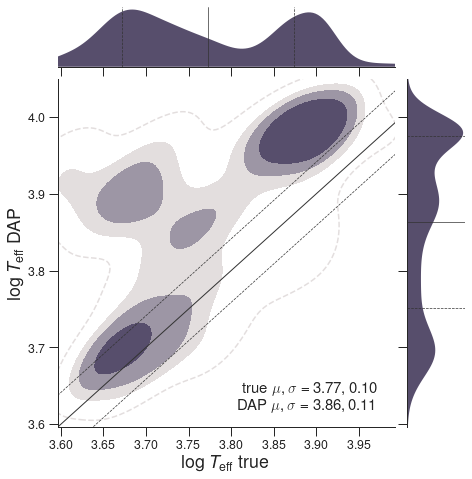

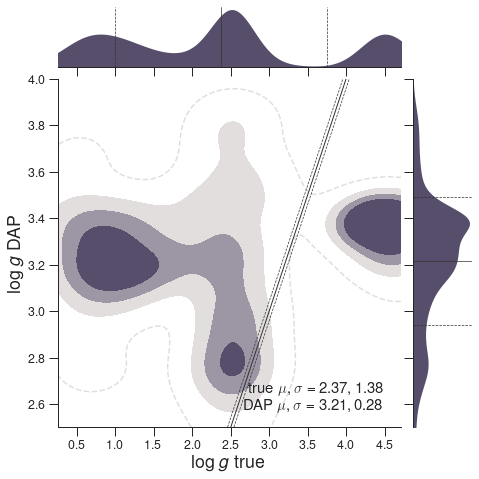

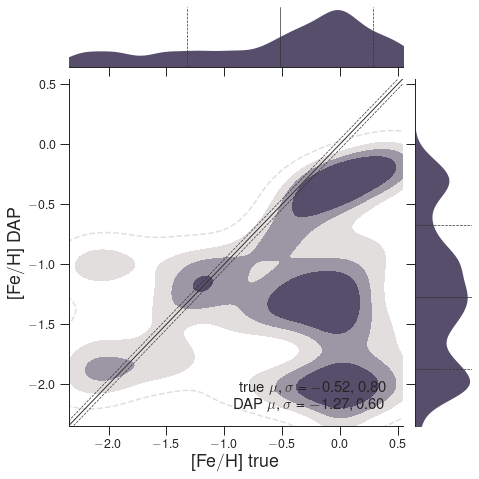

In [24]:
comparison_table = build_comparison_table(
    tablea=model_param_table.rename(columns=labels),
    tableb=true_param_table.rename(columns=labels),
    labela="DAP",
    labelb="true",
    columns=labels.values()
)
g = consistency_plot(
    comparison_table=comparison_table,
    column=list(labels.values())[0], unit="", is_logscale=True,
    labelx="true", labely="DAP", guide_color="0.2"
)
g.ax_joint.set_ylim((g.ax_joint.get_ylim()[0],4.05));
g.fig.savefig(os.path.join(fig_path, f"rsp-{experiment}-teff.png"), bbox_inches="tight")

g = consistency_plot(
    comparison_table=comparison_table,
    column=list(labels.values())[1], unit="", is_logscale=True,
    labelx="true", labely="DAP", guide_color="0.2"
)
g.ax_joint.set_ylim((2.5,4));
g.fig.savefig(os.path.join(fig_path, f"rsp-{experiment}-logg.png"), bbox_inches="tight")

g = consistency_plot(
    comparison_table=comparison_table,
    column=list(labels.values())[2], unit="", is_logscale=True,
    labelx="true", labely="DAP", guide_color="0.2"
)
g.fig.savefig(os.path.join(fig_path, f"rsp-{experiment}-met.png"), bbox_inches="tight")